In [1]:
# https://www.kaggle.com/hmavrodiev/bike-sharing-prediction-rf-xgboost/data?select=london_merged.csv
# Goal is predicting bike share demand in London
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

wd="C:/Users/Abhinav/Desktop/Data-Analysis/Bike sharing prediction/"
os.chdir(wd)

In [2]:
from sklearn.model_selection import cross_validate


def get_regression_cv_score(model, X, y, scoring, cv=7):
    # used to compare classifiers
    
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
    # cross_validate can also be used to evaluate regression models
    train_scores = scores['train_score']
    val_scores = scores['test_score']
    
    train_mean = np.mean(train_scores)
    val_mean = np.mean(val_scores)
    
    return train_mean, val_mean

###  1. Loading bike share data in London

In [3]:
london=pd.read_csv("london_merged.csv")

london.head()
#london.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [4]:
london.shape

(17414, 10)

In [5]:
london['timestamp'] = pd.to_datetime(london['timestamp'], format ="%Y-%m-%d %H:%M:%S")

In [6]:
london['weather_code'].unique()
#1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity
#2 = scattered clouds / few clouds
#3 = Broken clouds
#4 = Cloudly
#7 = Rain/ light Rain shower/ Light rain
#10 = rain with thunderstorm
#26 = snowfall
#94 = Freezing Fog


array([ 3.,  1.,  4.,  7.,  2., 26., 10.])

In [7]:
weather_dict = {1 : 100,  2 : 100,  3 : 100,  4 : 100, 
                7 : 200, 10 : 200, 26 : 200, 94 : 200}
london['weather_code']=london['weather_code'].replace(weather_dict)

london['weather_code'].unique()


array([100., 200.])

In [8]:
london['count_log'] = np.log1p(london['cnt'])

# The data contains zero values, so "log1p" adds 1 to the data and then calculates the natural logarithm function.

### 2. EDA and plots

In [9]:
london_non_weekend = london[london['is_weekend'] == 0]
london_non_weekend = london_non_weekend.drop(['is_holiday','is_weekend'],axis=1)

london_is_weekend = london[london['is_weekend'] == 1]
london_is_weekend = london_is_weekend.drop(['is_holiday','is_weekend'],axis=1)

london_is_holiday = london[london['is_holiday'] == 1]
london_is_holiday = london_is_holiday.drop(['is_holiday','is_weekend'],axis=1)

london_non_holiday = london[london['is_holiday'] == 0]
london_non_holiday = london_non_holiday.drop(['is_holiday','is_weekend'],axis=1)

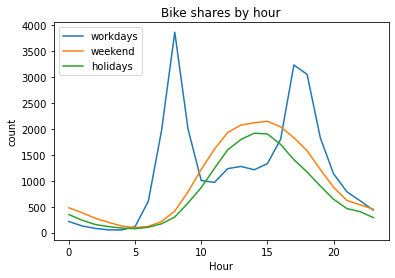

In [10]:
def hourly_plot(df,title):
    """
    Function for plotting bike shares by hour.
    input: 
    df - pandas dataframe 
    title - main title of the plot
    
    """
    
    df.groupby(by=df.timestamp.dt.hour)['cnt'].mean().plot()
    plt.title(title)
    plt.xlabel('Hour')
    plt.ylabel('count')
    plt.legend(['workdays','weekend','holidays'],loc=2, fontsize = 'medium')
    
hourly_plot(london_non_weekend, 'Bike shares by hour')
hourly_plot(london_is_weekend, 'Bike shares by hour')
hourly_plot(london_is_holiday, 'Bike shares by hour')

Text(0.5, 1.0, 'Bikes vs season')

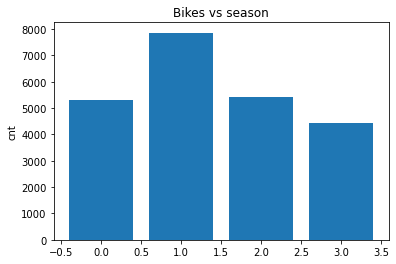

In [11]:
plt.bar(london_non_weekend["season"], london_non_weekend["cnt"])
plt.ylabel("cnt")
plt.title("Bikes vs season")

#"season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

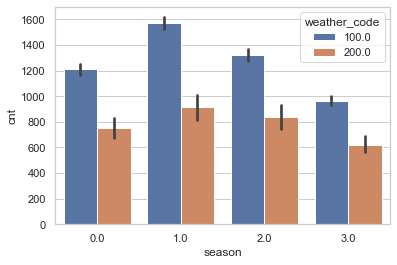

In [12]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
sns.barplot(x=london_non_weekend["season"], y=london_non_weekend["cnt"], hue=london_non_weekend["weather_code"], data=tips)

Text(0.5, 1.0, 'Correlation Between Features Heatmap style')

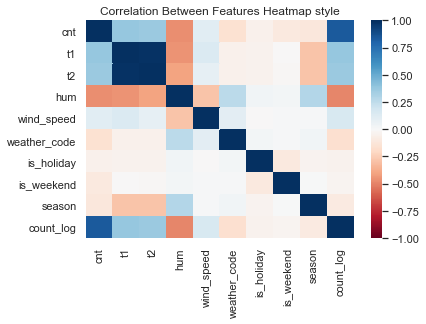

In [13]:
data_corr = london.corr(method='pearson')
ax = sns.heatmap(data_corr, vmin=-1, vmax=1, annot=False ,fmt=".2f", cmap='RdBu')
ax.set_title("Correlation Between Features Heatmap style")

### 3. Feature engineering

In [14]:
def add_features(df): 
    
    df['is_non_workday'] = df['is_holiday'] + df['is_weekend']
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year
    df['day']=df['timestamp'].dt.dayofweek
    df['hour'] = df['timestamp'].dt.hour
    
    df['is_night'] = 0
    df.loc[(df['hour'] < 8) | (df['hour'] > 20), 'is_night'] = 1
    
    return df

In [15]:
london=add_features(london)
london.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,count_log,is_non_workday,month,year,day,hour,is_night
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,100.0,0.0,1.0,3.0,5.209486,1.0,1,2015,6,0,1
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,100.0,0.0,1.0,3.0,4.934474,1.0,1,2015,6,1,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,100.0,0.0,1.0,3.0,4.905275,1.0,1,2015,6,2,1
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,100.0,0.0,1.0,3.0,4.290459,1.0,1,2015,6,3,1
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,100.0,0.0,1.0,3.0,3.871201,1.0,1,2015,6,4,1


### By night or day

Text(0.5, 1.0, 'Bikes by night')

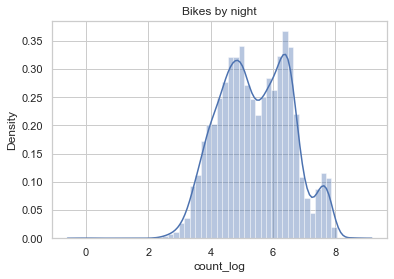

In [16]:
# Histogram


sns.distplot(london[london['is_night']==1]['count_log'])
plt.ylabel('Density')
plt.title("Bikes by night")

Text(0.5, 1.0, 'Bikes by daytime')

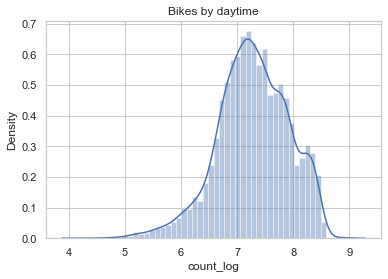

In [17]:

sns.distplot(london[london['is_night']==0]['count_log'])
plt.ylabel('Density')
plt.title("Bikes by daytime")

### By Hour

Text(0.5, 1.0, 'Bikes vs hour')

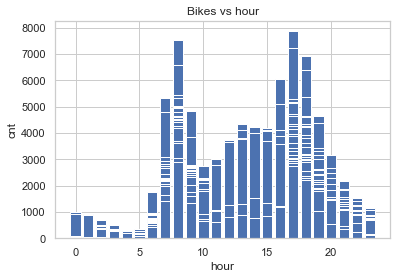

In [18]:
plt.bar(london["hour"], london["cnt"])
plt.ylabel("cnt")
plt.xlabel("hour")
plt.title("Bikes vs hour")

In [19]:
### By Month

Text(0.5, 1.0, 'Bikes vs month')

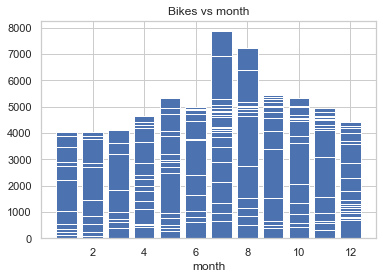

In [20]:
plt.bar(london["month"], london["cnt"])
plt.xlabel("month")
plt.title("Bikes vs month")

In [21]:
### By weekday

Text(0.5, 1.0, 'Bikes vs weekday')

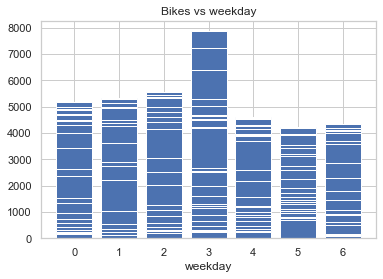

In [22]:
plt.bar(london["day"], london["cnt"])
plt.xlabel("weekday")
plt.title("Bikes vs weekday")

### 4. Machine Learning

In [23]:
london_df = london.drop(['timestamp','cnt','is_holiday','is_weekend','year'],axis=1)
X = london_df.drop(['count_log'], axis=1)
y = london_df['count_log']

X.head()

,t1,t2,hum,wind_speed,weather_code,season,is_non_workday,month,day,hour,is_night
0,3.0,2.0,93.0,6.0,100.0,3.0,1.0,1,6,0,1
1,3.0,2.5,93.0,5.0,100.0,3.0,1.0,1,6,1,1
2,2.5,2.5,96.5,0.0,100.0,3.0,1.0,1,6,2,1
3,2.0,2.0,100.0,0.0,100.0,3.0,1.0,1,6,3,1
4,2.0,0.0,93.0,6.5,100.0,3.0,1.0,1,6,4,1


In [24]:
from sklearn.preprocessing import StandardScaler
sc_x= StandardScaler()
X = sc_x.fit_transform(X)


In [25]:
# split into test and train sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)


### Pick an algorithm

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor


model_list = [LinearRegression(),
              RandomForestRegressor(random_state=42),
              GradientBoostingRegressor(random_state=42),
              SVR(),
              AdaBoostRegressor(random_state=42),
              BaggingRegressor(random_state=42)    
            ]

train_scores = []
test_scores = []

for model in model_list:
    mean_train_score, mean_test_score = get_regression_cv_score(model, X_train, y_train,'r2')
    # for values other than 'accuracy' 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    train_scores.append(mean_train_score)
    test_scores.append(mean_test_score)
    
models_score = sorted(list(zip(test_scores, train_scores, model_list)), reverse=True) # reverse based on test scores

print("-------------------------------------")
for test, train, model in models_score:
    print("Model: {} ".format(model.__class__.__name__))

    print("train_score: {:.3f}".format(train)) 

    print("validation_score: {:.3f}".format(test)) 

    print("-------------------------------------")

-------------------------------------
Model: RandomForestRegressor 
train_score: 0.995
validation_score: 0.967
-------------------------------------
Model: BaggingRegressor 
train_score: 0.993
validation_score: 0.963
-------------------------------------
Model: GradientBoostingRegressor 
train_score: 0.946
validation_score: 0.943
-------------------------------------
Model: AdaBoostRegressor 
train_score: 0.846
validation_score: 0.843
-------------------------------------
Model: SVR 
train_score: 0.762
validation_score: 0.747
-------------------------------------
Model: LinearRegression 
train_score: 0.656
validation_score: 0.655
-------------------------------------


### Tuning parameters for the best models

### 1. Random forest regressor

In [27]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor(random_state=42)

parameters = {'n_estimators': [50, 100, 200],
              'max_depth': [2, 3, 4]}

grid1 = GridSearchCV(model, parameters, cv=7, scoring='r2',return_train_score=True)
grid1.fit(X_train, y_train)

print(grid1.best_params_)
best_train = grid1.cv_results_["mean_train_score"][grid1.best_index_]
print("best mean_train_score: {:.3f}".format(best_train))
        
best_test = grid1.cv_results_["mean_test_score"][grid1.best_index_]
print("best mean_test_score: {:.3f}".format(best_test))

{'max_depth': 4, 'n_estimators': 100}
best mean_train_score: 0.843
best mean_test_score: 0.841


### 2. Gradient Boosted Regressor

In [28]:
model = GradientBoostingRegressor(max_depth=5, random_state=42)

parameters = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0]}

grid2 = GridSearchCV(model, parameters, cv=7, scoring='r2', return_train_score=True)
grid2.fit(X_train, y_train)


print(grid2.best_params_)
best_train = grid2.cv_results_["mean_train_score"][grid2.best_index_]
print("best mean_train_score: {:.3f}".format(best_train))
        
best_test = grid2.cv_results_["mean_test_score"][grid2.best_index_]
print("best mean_test_score: {:.3f}".format(best_test))


C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_losses.py:211: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_losses.

C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\metrics\_regression.py:598: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_losses.py:211: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_

C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_losses.py:211: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_losses.py:211: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_los

C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_losses.py:211: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_losses.

C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_losses.py:211: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_losses.py:211: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_los

C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_losses.py:211: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_losses.py:211: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_losses.py:211: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumer

C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_losses.py:211: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\ensemble\_gb_losses.py:211: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\Abhinav\anaconda3py3\lib\site-packages\numpy\core\fromnumeric.p

C:\Users\Abhinav\anaconda3py3\lib\site-packages\sklearn\model_selection\_search.py:813: RuntimeWarning: overflow encountered in square
  array_stds = np.sqrt(np.average((array -


{'learning_rate': 0.1, 'n_estimators': 200}
best mean_train_score: 0.981
best mean_test_score: 0.970


### 4. Final Model Scoring

### Gradient Boosted Regression

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#pipeline = Pipeline([('preprocessing', StandardScaler()), ('regressor', grid2.best_estimator_)]) 
pipeline = Pipeline([('regressor', grid2.best_estimator_)]) # same result without preprocessing (update!!)

# Note 'classifier' or 'regressor' can be named as anything its just the step name. https://scikit-learn.org/stable/modules/compose.html

pipeline.fit(X_train, y_train)

print("Test score: {:.3f}".format(pipeline.score(X_test, y_test))) # should be same as r2_score() below for test



Test score: 0.972


In [30]:

y_pred=pipeline.predict(X_test)
y_pred_train=pipeline.predict(X_train)

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

mae=mean_absolute_error(y_test, y_pred)
mse=mean_squared_error(y_test, y_pred)
rmse=np.sqrt(mse)
rmse

0.21267892035529648

In [31]:
from sklearn.metrics import r2_score

r2_score=r2_score(y_test, y_pred)
r2_score


0.9722729444902145